In [1]:
# necessary packages #

using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
Sys.free_memory()/(2^20*1024)

12.912891387939453

In [5]:
@load "../../results/BSLMC_Factor/BSLMC_Factor_sum_data.jld"

11-element Array{Symbol,1}:
 :Y_ord     
 :S_indx    
 :U_indx    
 :M_Sind    
 :U_ind     
 :K         
 :p         
 :q         
 :N_sam     
 :N_pre_burn
 :NM        

In [6]:
@load "../../results/BSLMC_Factor/BSLMC_Factor_mean_var.jld"

8-element Array{Symbol,1}:
 :ω_incp_sam_mean  
 :ω_incp_sam_var   
 :Y_m_sam_mean     
 :Y_m_sam_var      
 :ω_incp_M_sam_mean
 :ω_incp_M_sam_var 
 :Y_M_sam_mean     
 :Y_M_sam_var      

In [7]:
p = 2; K = 2; q = 10;

In [8]:
#load data
using CSV
ϕ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC_Factor/ϕ_sam_nopredC.csv"));
N_sam = Integer(length(ϕ_sam) / K - 1);
ind_ϕ_sam = 1: K :(K * N_sam + 1);
A_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC_Factor/A_sam_nopredC.csv"));
ind_A_sam = 1: K :(K * (N_sam - 1) + 1);
γ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC_Factor/γ_sam_nopredC.csv"));
ind_γ_sam = (1: (p + K) :((p + K) * N_sam + 1));
Σ_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC_Factor/Σ_sam_nopredC.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, CSV.read("../../results/BSLMC_Factor/ω_cov_sam_nopredC.csv"));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);

In [9]:
N_sam

10000

In [10]:
mean(A_sam[ind_A_sam])

0.21125346316528001

In [11]:
mean(A_sam[ind_A_sam .+ 1])

0.2826228628125296

In [12]:
size(Y_ord)

(1020000, 10)

In [13]:
NM

12057

In [14]:
[length(M_Sind[i]) for i in 1:10]

10-element Array{Int64,1}:
 100799
 100768
 100787
 100767
 100812
 100814
 100770
 100792
 100805
 100794

In [15]:
tt = union(union(union(union(union(union(union(union(union(M_Sind[1], M_Sind[2]), M_Sind[3]),
                            M_Sind[4]), M_Sind[5]), M_Sind[6]), M_Sind[7]), M_Sind[8]), 
        M_Sind[9]), M_Sind[10]);
length(tt)

656366

Posterior prediction

# MCMC Chain check

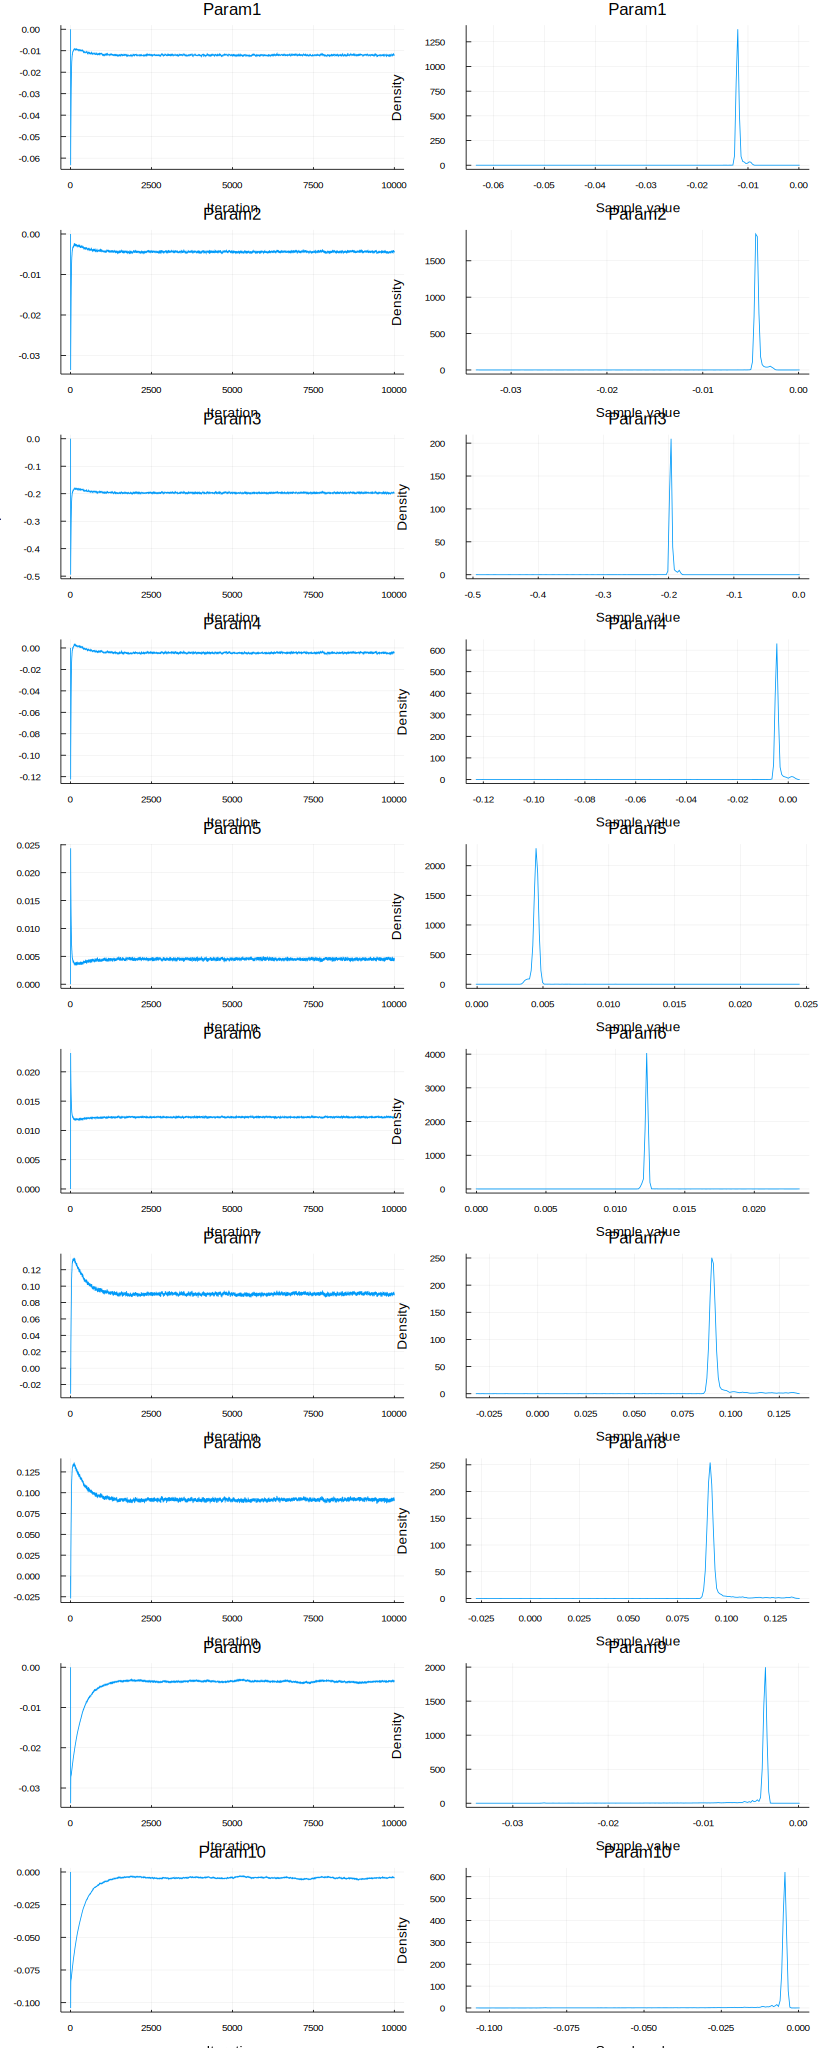

In [16]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, (p -1) * q, 1);
β_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1) , j][1:(N_sam + 1)] 
        for i in 2:2, j in 1:q]...);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [17]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1 , (K -1) * q, 1);
Λ_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1), j][1:(N_sam + 1)] 
        for i in (p + 2):(p + 2), j in 1:q]...);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain);

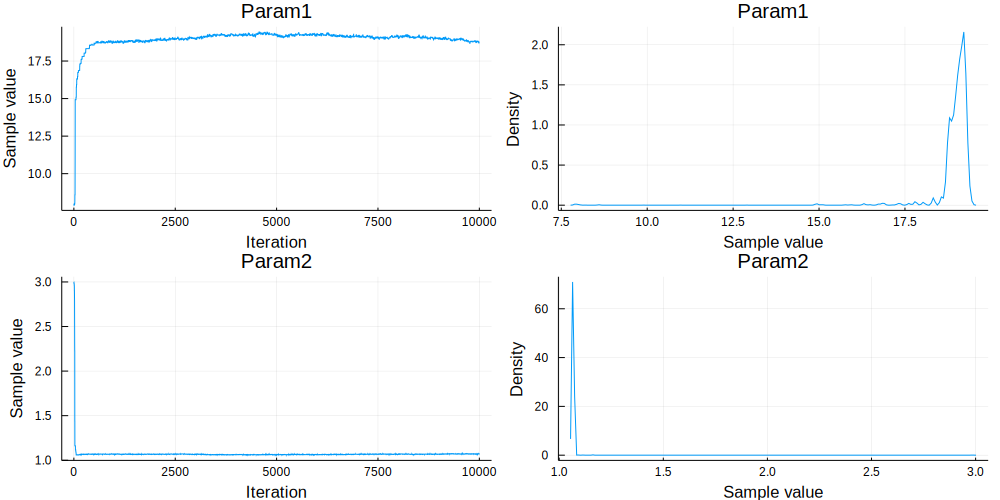

In [26]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat([(ϕ_sam[ind_ϕ_sam .+ (i - 1)][1:(N_sam + 1)]) for i in 1:K]...);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

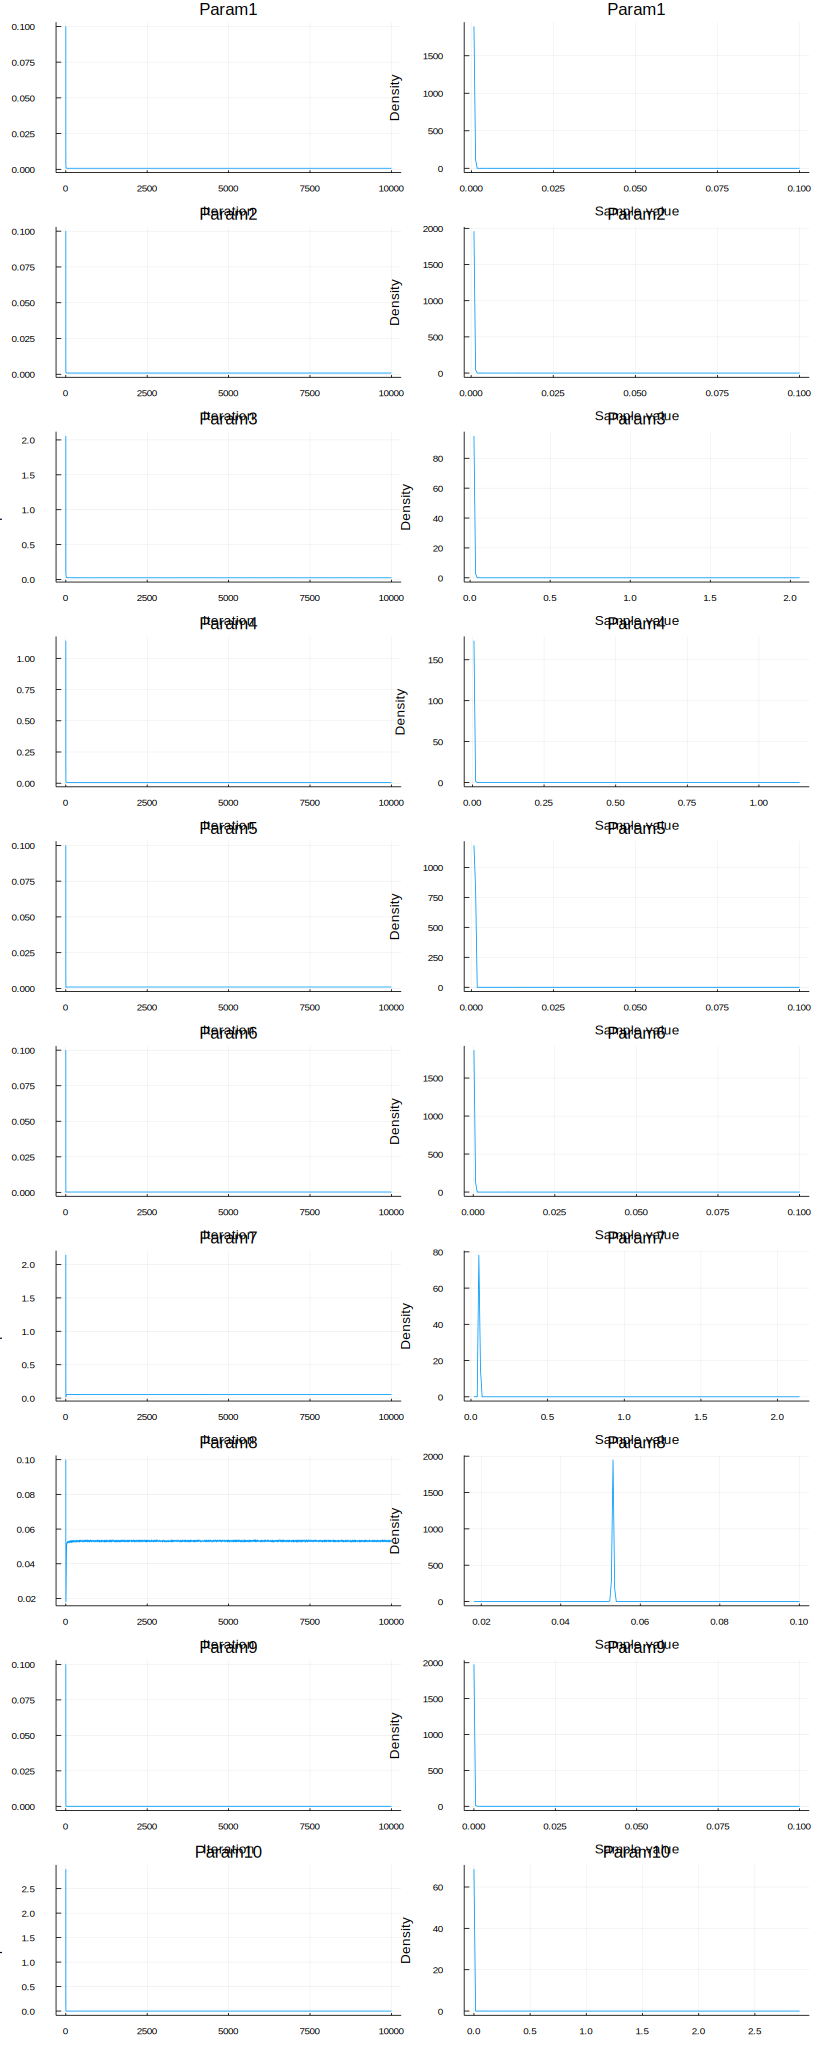

In [19]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1 , q, 1);
Σ_pos_sam[:, :, 1] =  hcat([Σ_sam[ind_Σ_sam .+ (i - 1)][1:(N_sam + 1)] for i in 1:q]...);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

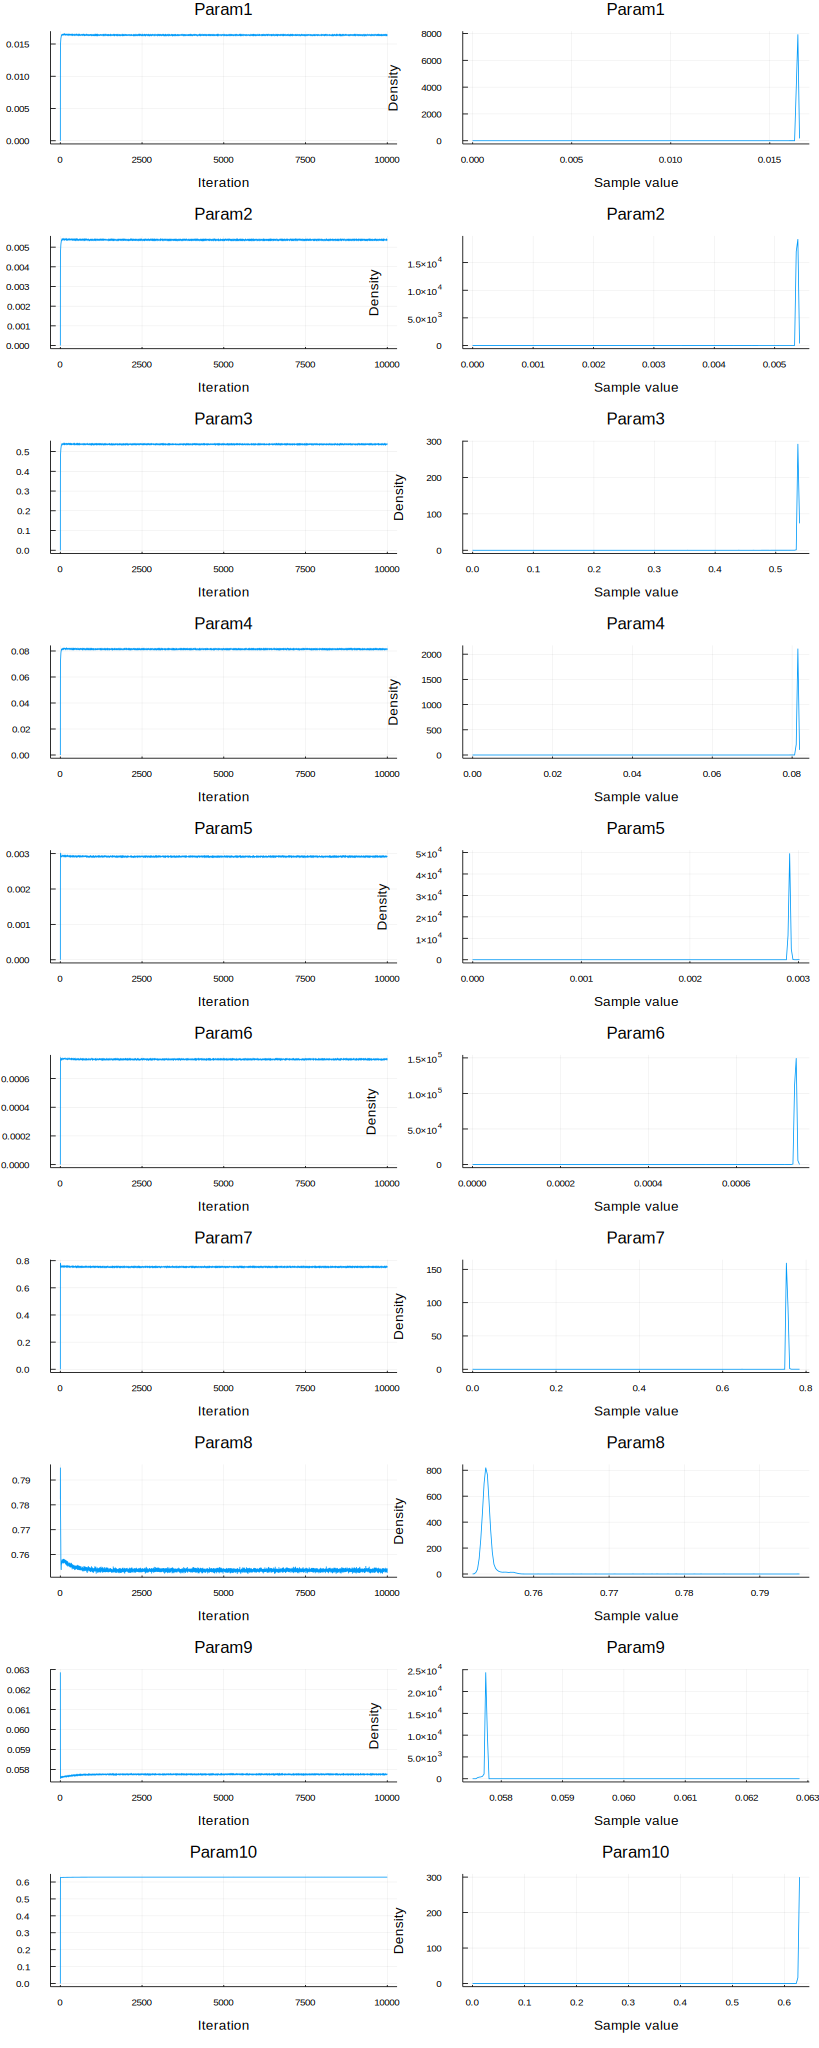

In [20]:
ω_cov_pos_sam = Array{Float64, 3}(undef, N_sam , q, 1);
ω_cov_pos_sam[:, :, 1] = hcat([ω_cov_sam[ind_ω_cov_sam .+ (i - 1), i][1:N_sam] 
        for i in 1:q]...);
ω_cov_chain = Chains(ω_cov_pos_sam);
pωcov = plot(ω_cov_chain)

In [21]:
ω_corr_sam = [(Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) 
                for i in 1:q]) * ω_cov_sam[ind_ω_cov_sam[l] .+ (1:q) .- 1, 1:q] * 
        Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q])) 
    for l in 1:N_sam];

In [22]:
[ω_corr_sam[i][1, 1] for i in 1:10]

10-element Array{Float64,1}:
 0.9999999999999998
 1.0               
 1.0               
 1.0000000000000002
 1.0               
 0.9999999999999999
 1.0               
 1.0000000000000002
 1.0               
 0.9999999999999998

In [23]:
ω_corr_sam_mean = [mean([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
    for j in 1:q, k in 1:q] 

10×10 Array{Float64,2}:
  1.0        0.999702   1.0       …   0.915472  -0.527541  -0.524515
  0.999702   1.0        0.999717      0.925014  -0.548105  -0.545125
  1.0        0.999717   1.0           0.915712  -0.528049  -0.525023
  0.997117   0.998671   0.997162      0.943367  -0.590486  -0.587611
 -0.994578  -0.991746  -0.994516     -0.868666   0.436341   0.433137
 -0.991718  -0.98829   -0.991641  …  -0.85621    0.414064   0.410822
  0.914328   0.923934   0.91457       0.999996  -0.826383  -0.824374
  0.915472   0.925014   0.915712      1.0       -0.824785  -0.822767
 -0.527541  -0.548105  -0.528049     -0.824785   1.0        0.999994
 -0.524515  -0.545125  -0.525023     -0.822767   0.999994   1.0     

In [24]:
ω_corr_sam_var = [var([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
    for j in 1:q, k in 1:q]

10×10 Array{Float64,2}:
 2.38627e-32  1.51272e-10  4.61456e-14  …  4.9514e-8    4.94513e-8 
 1.51272e-10  2.35569e-32  1.41238e-10     1.44648e-7   1.44884e-7 
 4.61456e-14  1.41238e-10  2.22942e-32     4.86722e-8   4.89016e-8 
 7.98732e-10  7.36117e-10  7.53336e-10     5.96135e-8   6.05633e-8 
 4.90614e-9   9.44348e-9   4.85623e-9      3.2851e-7    3.28749e-7 
 7.66822e-9   1.4146e-8    7.80999e-9   …  3.43298e-7   3.44761e-7 
 2.35701e-8   4.03648e-8   2.45812e-8      3.10515e-8   3.13487e-8 
 2.36056e-8   4.13209e-8   2.42892e-8      3.07774e-8   3.08408e-8 
 4.9514e-8    1.44648e-7   4.86722e-8      2.53622e-32  8.26854e-15
 4.94513e-8   1.44884e-7   4.89016e-8      8.26854e-15  2.18701e-32

In [25]:
ω_cov_pos_sam_mean = [mean(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) 
    for i in 1:q, j in 1:q] 

10×10 Array{Float64,2}:
  0.0163881    0.00937912   0.0938075  …  -0.0162299   -0.0532484 
  0.00937912   0.00537097   0.0536879     -0.0096535   -0.0316816 
  0.0938075    0.0536879    0.536964      -0.0929911   -0.305095  
  0.036423     0.020884     0.208498      -0.040492    -0.132965  
 -0.00687608  -0.00392522  -0.0393569      0.00566315   0.0185501 
 -0.00343939  -0.00196218  -0.0196859  …   0.00269582   0.00882605
  0.101645     0.058801     0.581978      -0.172462    -0.567709  
  0.101741     0.058852     0.58253       -0.172077    -0.566432  
 -0.0162299   -0.0096535   -0.0929911      0.057755     0.190579  
 -0.0532484   -0.0316816   -0.305095       0.190579     0.628881  

In [26]:
# check the plot of the data 
using RCall
@rput ω_corr_sam_mean
R"""
library(corrplot)
library(corrgram)

colnames(ω_corr_sam_mean) <- c("NDVI", "EVI","GPP", "PsnNet", 
                         "red refl", "blue refl", 
                         "LE", "ET", "PLE", "PET")
rownames(ω_corr_sam_mean) <- c("NDVI", "EVI","GPP", "PsnNet", 
                         "red reflectance", "blue reflectance", 
                         "LE", "ET", "PLE", "PET")

width <- 720
height <- 720
pointsize <- 16


png(paste("../../pics/BSLMC_factor_corr_plot.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
#corrplot(ω_corr_sam_mean, method="number", type = "upper", diag = FALSE, 
#         addshade = "negative", number.digits = 2, tl.pos = "td")

corrgram(ω_corr_sam_mean, order=FALSE, lower.panel=panel.shade, gap = 0.2,
         upper.panel=panel.pie, text.panel=panel.txt, main=" ",
         col.regions = colorRampPalette(c( "darkseagreen3",
                                           "white", "cadetblue3")))
dev.off()
"""

┌ Warning: RCall.jl: corrplot 0.84 loaded
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Registered S3 method overwritten by 'seriation':
│   method         from 
│   reorder.hclust gclus
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


RObject{IntSxp}
null device 
          1 


# Posterior Inference 

In [27]:
summary_table = Array{Float64, 2}(undef, 22, 5);
summary_table[1, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 5, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 5, 1], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 6, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 6, 1], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 7, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 7, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 8, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 8, 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 9, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 9, 1], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 10, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 10, 1], [0.5, 0.025, 0.975]));
summary_table[11, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1], [0.5, 0.025, 0.975]));
summary_table[12, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1], [0.5, 0.025, 0.975]));
summary_table[13, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1], [0.5, 0.025, 0.975]));
summary_table[14, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1], [0.5, 0.025, 0.975]));
summary_table[15, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 5, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 5, 1], [0.5, 0.025, 0.975]));
summary_table[16, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 6, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 6, 1], [0.5, 0.025, 0.975]));
summary_table[17, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 7, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 7, 1], [0.5, 0.025, 0.975]));
summary_table[18, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 8, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 8, 1], [0.5, 0.025, 0.975]));
summary_table[19, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 9, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 9, 1], [0.5, 0.025, 0.975]));
summary_table[20, :] = vcat(0.0, mean(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 10, 1]),
    quantile(Σ_pos_sam[(N_pre_burn + 1):(N_sam + 1), 10, 1], [0.5, 0.025, 0.975]));
summary_table[21, :] = vcat(0.0, mean(ϕ_sam[ind_ϕ_sam][(N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[ind_ϕ_sam][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]));
summary_table[22, :] = vcat(0.0, mean(ϕ_sam[ind_ϕ_sam .+ 1][(N_pre_burn + 1):N_sam]),
    quantile(ϕ_sam[ind_ϕ_sam .+ 1][(N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 6);
rnames = ["β[2, 1]","β[2, 2]", "β[2, 3]", "β[2, 4]","β[2, 5]", "β[2, 6]", 
    "β[2, 7]","β[2, 8]", "β[2, 9]", "β[2, 10]", "Σ_1", "Σ_2", "Σ_3", 
    "Σ_4", "Σ_5", "Σ_6", "Σ_7", "Σ_8", "Σ_9", "Σ_10", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|          | true |      mean |    median |      2.5% |     97.5% |
|----------|------|-----------|-----------|-----------|-----------|
|  β[2, 1] |  0.0 | -0.012055 | -0.012057 |  -0.01249 | -0.011641 |
|  β[2, 2] |  0.0 | -0.004391 | -0.004395 | -0.004709 | -0.004087 |
|  β[2, 3] |  0.0 | -0.196891 | -0.196882 |  -0.19931 | -0.194493 |
|  β[2, 4] |  0.0 | -0.004547 | -0.004531 | -0.005535 | -0.003577 |
|  β[2, 5] |  0.0 |  0.004492 |  0.004491 |  0.004188 |  0.004798 |
|  β[2, 6] |  0.0 |  0.012262 |  0.012261 |  0.012108 |  0.012418 |
|  β[2, 7] |  0.0 |  0.090519 |  0.090532 |  0.088005 |  0.092909 |
|  β[2, 8] |  0.0 |  0.091637 |  0.091647 |  0.088944 |  0.094107 |
|  β[2, 9] |  0.0 | -0.003564 | -0.003557 | -0.003838 | -0.003311 |
| β[2, 10] |  0.0 | -0.004625 | -0.004611 |  -0.00554 | -0.003788 |
|      Σ_1 |  0.0 |  0.000745 |  0.000746 |  0.000743 |  0.000748 |
|      Σ_2 |  0.0 |  0.000868 |  0.000868 |  0.000865 |   0.00087 |
|      Σ_3 |  0.0 |  0.024403 |  0.024403 |  0.0

In [28]:
# MAE #
MAE = (sum(abs.(Y_ord[U_indx, :] - Y_M_sam_mean)) + 
    sum([sum(abs.(Y_m_sam_mean[i] - Y_ord[S_indx[M_Sind[i]], i])) for i in 1:q])) / 
    (sum([length(M_Sind[i]) for i in 1:q]) + q * length(U_indx))
MAE_list = fill(0.0, q);
for i in 1:q
    MAE_list[i] = (sum(abs.(Y_ord[U_indx, i] - Y_M_sam_mean[:, i])) + 
    sum(abs.(Y_m_sam_mean[i] - Y_ord[S_indx[M_Sind[i]], i]))) / 
    (length(M_Sind[i]) + length(U_indx))
end
print(round.(MAE_list, digits = 4))
print(round(MAE, digits = 4))

[0.0252, 0.021, 0.1562, 0.0615, 0.0263, 0.0132, 0.2143, 0.2137, 0.009, 0.0291]0.077

In [29]:
# RMSPE #
MSPE = (sum((Y_ord[U_indx, :] - Y_M_sam_mean).^2) + 
    sum([sum((Y_m_sam_mean[i] - Y_ord[S_indx[M_Sind[i]], i]).^2) for i in 1:q])) / 
    (sum([length(M_Sind[i]) for i in 1:q]) + q * length(U_indx))
RMSPE = sqrt(MSPE); 
print(round.([sqrt((sum((Y_ord[U_indx, i] - Y_M_sam_mean[:, i]).^2) + 
        sum((Y_m_sam_mean[i] - Y_ord[S_indx[M_Sind[i]], i]).^2)) / 
        (length(M_Sind[i]) + length(U_indx))) for i in 1:q], digits = 4));
print(round(RMSPE, digits = 4));

[0.038, 0.0314, 0.2209, 0.0866, 0.0335, 0.017, 0.2785, 0.278, 0.02, 0.066]0.1482

In [50]:
# CRPS #
CRPS_list = [Array{Float64}(undef, length(M_Sind[i])) for i in 1:q];
for i in 1:q
    CRPS_list[i] = (sqrt.(Y_m_sam_var[i]) .* ( 1 /sqrt(π) .- 
        2 * pdf.(Normal(), (Y_ord[S_indx[M_Sind[i]], i] - Y_m_sam_mean[i]) ./ 
                    sqrt.(Y_m_sam_var[i])) .-
        ((Y_ord[S_indx[M_Sind[i]], i] - Y_m_sam_mean[i]) ./ sqrt.(Y_m_sam_var[i])) .* 
        (2 * cdf.(Normal(), (Y_ord[S_indx[M_Sind[i]], i] - Y_m_sam_mean[i]) ./ 
                        sqrt.(Y_m_sam_var[i])) .- 1 )));
end
CRPS_M = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];
print(round.([((sum(CRPS_list[i]) + sum(CRPS_M[:, i])) / 
        (length(M_Sind[i]) + NM)) for i in 1:q], digits = 4))
print(round((sum(sum.(CRPS_list)) + sum(CRPS_M)) / 
    (sum(length.(M_Sind)) + NM * q), digits = 4))

[-0.0187, -0.016, -0.1119, -0.0453, -0.0186, -0.0094, -0.1494, -0.1489, -0.007, -0.0228]-0.0548

In [51]:
# CVG #
N_Inf_burn = 1;
count_Y_M = fill(0.0, q);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[U_indx[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[U_indx[i], j]))
    end
end
for j in 1:q
    for i in 1:length(M_Sind[j])
        count_Y_M[j] = count_Y_M[j] + 
            (((Y_m_sam_mean[j][i] - 1.96 * sqrt(Y_m_sam_var[j][i])) < Y_ord[S_indx[M_Sind[j][i]], j]) && 
             ((Y_m_sam_mean[j][i] + 1.96 * sqrt(Y_m_sam_var[j][i])) > Y_ord[S_indx[M_Sind[j][i]], j]))
    end
end
print(round.([count_Y_M[i] / (length(M_Sind[i]) + length(U_indx)) for i in 1:q], digits = 3))
print(round(sum(count_Y_M) / sum([(length(M_Sind[i]) + length(U_indx)) for i in 1:q]), digits = 3))

[0.948, 0.957, 0.951, 0.963, 0.945, 0.946, 0.953, 0.954, 0.984, 0.984]0.958

In [59]:
# INT #
INT_list = [Array{Float64}(undef, length(M_Sind[i])) for i in 1:q];
for i in 1:q
    INT_list[i] = ((2 * 1.96 * sqrt.(Y_m_sam_var[i])) .+ 
                (2 / 0.05) * (Y_m_sam_mean[i] .- 1.96 * sqrt.(Y_m_sam_var[i]) .- 
            Y_ord[S_indx[M_Sind[i]], i]) .* 
                (Y_ord[S_indx[M_Sind[i]], i] .< (Y_m_sam_mean[i] .- 1.96 * sqrt.(Y_m_sam_var[i]))) + 
                (2 / 0.05) * (Y_ord[S_indx[M_Sind[i]], i] - Y_m_sam_mean[i] .- 
            1.96 * sqrt.(Y_m_sam_var[i])) .* 
                (Y_ord[S_indx[M_Sind[i]], i] .> (Y_m_sam_mean[i] + 1.96 * sqrt.(Y_m_sam_var[i]))));
end
INT_M = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i]) - Y_ord[U_indx[i], j]) * 
                (Y_ord[U_indx[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[U_indx[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:NM, j in 1:q]
print(round.([((sum(INT_list[i]) + sum(INT_M[:, i])) / 
        (length(M_Sind[i]) + NM)) for i in 1:q], digits = 4))
print(round((sum(sum.(INT_list)) + sum(INT_M)) / 
    (sum(length.(M_Sind)) + NM * q), digits = 4))

[0.2002, 0.1898, 1.0453, 0.4757, 0.1394, 0.0586, 1.222, 1.222, 0.0765, 0.2528]0.4882

In [37]:
[sqrt(var(Y_ord[:, i])) for i in 1:q];

In [39]:
using RData
data_cleaned = load("../../data/rawdata/data_cleaned_small_expanded.RData", convert = true)["data_cleaned_small"];

In [40]:
coords_xy = hcat((round.((data_cleaned.x[S_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[S_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
coords_xy_pred = hcat((round.((data_cleaned.x[U_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[U_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
ω_incp_fit = vcat(ω_incp_sam_mean, ω_incp_M_sam_mean); coords_xy_ω = vcat(coords_xy, coords_xy_pred);
Y_fit_1 = vcat(copy(Y_ord[S_indx, 1]), Y_M_sam_mean[:, 1]); Y_fit_1[M_Sind[1]] = Y_m_sam_mean[1];
Y_fit_2 = vcat(copy(Y_ord[S_indx, 2]), Y_M_sam_mean[:, 2]); Y_fit_2[M_Sind[2]] = Y_m_sam_mean[2];
Y_fit_3 = vcat(copy(Y_ord[S_indx, 3]), Y_M_sam_mean[:, 3]); Y_fit_3[M_Sind[3]] = Y_m_sam_mean[3];
Y_fit_4 = vcat(copy(Y_ord[S_indx, 4]), Y_M_sam_mean[:, 4]); Y_fit_4[M_Sind[4]] = Y_m_sam_mean[4];
Y_fit_5 = vcat(copy(Y_ord[S_indx, 5]), Y_M_sam_mean[:, 5]); Y_fit_5[M_Sind[5]] = Y_m_sam_mean[5];
Y_fit_6 = vcat(copy(Y_ord[S_indx, 6]), Y_M_sam_mean[:, 6]); Y_fit_6[M_Sind[6]] = Y_m_sam_mean[6];
Y_fit_7 = vcat(copy(Y_ord[S_indx, 7]), Y_M_sam_mean[:, 7]); Y_fit_7[M_Sind[7]] = Y_m_sam_mean[7];
Y_fit_8 = vcat(copy(Y_ord[S_indx, 8]), Y_M_sam_mean[:, 8]); Y_fit_8[M_Sind[8]] = Y_m_sam_mean[8];
Y_fit_9 = vcat(copy(Y_ord[S_indx, 9]), Y_M_sam_mean[:, 9]); Y_fit_9[M_Sind[9]] = Y_m_sam_mean[9];
Y_fit_10 = vcat(copy(Y_ord[S_indx, 10]), Y_M_sam_mean[:, 10]); Y_fit_10[M_Sind[10]] = Y_m_sam_mean[10];


In [42]:
# check the plot of the data 
using RCall
@rput Y_ord
@rput M_Sind  
@rput S_indx U_indx
@rput coords_xy
@rput coords_xy_ω
@rput ω_incp_fit
@rput Y_fit_1 Y_fit_2 Y_fit_3 Y_fit_4 Y_fit_5 Y_fit_6 Y_fit_7 Y_fit_8 Y_fit_9 Y_fit_10
R"""
library(MBA)
library(classInt)
library(RColorBrewer)
library(sp)
library(coda)
library(spBayes)
library(fields)
library(rworldmap)
library(rworldxtra)
library(raster)
library(leaflet)

raw1.data <- data.frame(x = coords_xy[-M_Sind[[1]], 1], y = coords_xy[-M_Sind[[1]], 2], 
        z =  Y_ord[S_indx[-M_Sind[[1]]], 1])
raw5.data <- data.frame(x = coords_xy[-M_Sind[[5]], 1], y = coords_xy[-M_Sind[[5]], 2], 
        z =  Y_ord[S_indx[-M_Sind[[5]]], 5])
raw1_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], 
        z =  Y_ord[c(S_indx, U_indx), 1])
raw5_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], 
        z =  Y_ord[c(S_indx, U_indx), 5])
fit_y1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_1)
fit_y5.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_5)
fit_incpw1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 1])
fit_incpw5.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 5])

coordinates(raw1.data) = ~x+y
gridded(raw1.data) = TRUE
raw1.data = as(raw1.data, "SpatialGridDataFrame")
projection(raw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw5.data) = ~x+y
gridded(raw5.data) = TRUE
raw5.data = as(raw5.data, "SpatialGridDataFrame")
projection(raw5.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw1_nomiss.data) = ~x+y
gridded(raw1_nomiss.data) = TRUE
raw1_nomiss.data = as(raw1_nomiss.data, "SpatialGridDataFrame")
projection(raw1_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw5_nomiss.data) = ~x+y
gridded(raw5_nomiss.data) = TRUE
raw5_nomiss.data = as(raw5_nomiss.data, "SpatialGridDataFrame")
projection(raw5_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y1.data) = ~x+y
gridded(fit_y1.data) = TRUE
fit_y1.data = as(fit_y1.data, "SpatialGridDataFrame")
projection(fit_y1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y5.data) = ~x+y
gridded(fit_y5.data) = TRUE
fit_y5.data = as(fit_y5.data, "SpatialGridDataFrame")
projection(fit_y5.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_incpw1.data) = ~x+y
gridded(fit_incpw1.data) = TRUE
fit_incpw1.data = as(fit_incpw1.data, "SpatialGridDataFrame")
projection(fit_incpw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_incpw5.data) = ~x+y
gridded(fit_incpw5.data) = TRUE
fit_incpw5.data = as(fit_incpw5.data, "SpatialGridDataFrame")
projection(fit_incpw5.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"



data <- c(raw1_nomiss.data$z, raw5_nomiss.data$z)
#, fit_y1.data$z, fit_y5.data$z, fit_incpw1.data$z, fit_incpw5.data$z)
surf.brks <- classIntervals(data[!is.na(data)], 500, 'pretty')$brks
col.pal <- colorRampPalette(brewer.pal(11,'RdBu')[11:1])
xlim <- c(range(coords_xy_ω[, 1])[1], range(coords_xy_ω[, 1])[2] + 
            0.13*(range(coords_xy_ω[, 1])[2] - range(coords_xy_ω[, 1])[1])) ;


zlim <- range(data[!is.na(data)])

# size for the mapping of w               
width <- 360*1.2
height <- 360
pointsize <- 16


png(paste("../../pics/BSLMC_factor_map-raw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-raw5.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw5.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-raw1_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-raw5_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw5_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()


png(paste("../../pics/BSLMC_factor_map-fit1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-fit5.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y5.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-incpw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/BSLMC_factor_map-incpw5.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw5.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

"""

RObject{IntSxp}
null device 
          1 
